In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import cdist
import os

**Generate data**

In [5]:
def generate_pair_fixed_norm(N, dim, s_target, sigma, rng, max_norm, hausdorf=False):
    """
    Generate a pair of point sets (A,B) each with N points in `dim` dimensions,
    such that the average similarity between matched points is around s_target,
    with per-point similarity noise of `sigma`. Similarity is defined as
    1 - (distance / max_norm), where max_norm is a fixed normalization constant."""
    A = rng.random((N, dim))
    # per-point similarities around s_target
    s_i = rng.normal(loc=s_target, scale=sigma, size=N)
    s_i = np.clip(s_i, 0.0, 1.0)
    
    # distances so that if normalized by max_norm similarity = s_i
    d_i = (1.0 - s_i) * max_norm
    # random directions
    dirs = rng.normal(size=(N, dim))
    dirs /= np.linalg.norm(dirs, axis=1, keepdims=True)
    if hausdorf:
        h_target = (1.0 - s_target) * max_norm
        
        r_i = np.minimum(d_i, h_target)
        k = rng.integers(0, N)
        r_i[k] = h_target
        B = A + dirs * r_i[:, None]
        D = cdist(A, B)
        d_ab = np.max(np.min(D, axis=1))  # for each A find nearest B, then worst
        d_ba = np.max(np.min(D, axis=0))  # for each B find nearest A, then worst
        haus = max(d_ab, d_ba)
        set_similarity = 1.0 - (haus / max_norm)
        set_similarity = float(np.clip(set_similarity, 0.0, 1.0))

        nearest_dist_A = np.min(D, axis=1)
        assigned_similarities = 1.0 - (nearest_dist_A / max_norm)
        assigned_similarities = np.clip(assigned_similarities, 0.0, 1.0)

        return A, B, s_i, set_similarity, assigned_similarities
    
    B = A + (dirs * d_i[:, None])
    # compute pairwise distances and similarity matrix using fixed max_norm Euclidean distance
    D = np.linalg.norm(A[:, None, :] - B[None, :, :], axis=2)
    S = 1 - (D / max_norm)
    S = np.clip(S, 0.0, 1.0)
    cost = 1 - S
    row_ind, col_ind = linear_sum_assignment(cost)
    assigned_similarities = S[row_ind, col_ind]
    set_similarity = assigned_similarities.mean()
    return A, B, s_i, set_similarity, assigned_similarities

# ---------------- dataset generator + train/test saver ----------------
def generate_and_save(
    out_train_path,
    out_test_path,
    M=8000,
    N=20,
    dim=5,
    sigma=0.03,
    rng_seed=42,
    test_fraction=0.2,
    max_norm_multiplier=1.0,
    save_label_as='similarity',   # 'similarity' or 'cost'
    shuffle_before_split=True,
    hausdorf=False,
    random_set_sizes=False
):
    """
    Generate M pairs (A,B) with N points in `dim` and save train/test .npz files
    with keys exactly: 'A', 'B', 'y' (so PairSetDataset works directly).

    Parameters:
    - out_train_path, out_test_path : target filenames
    - M : number of pairs total
    - N : points per set
    - dim : dimension
    - sigma : per-point similarity noise (small keeps actual close to target)
    - test_fraction : fraction reserved for test set (default 0.2)
    - max_norm_multiplier : multiplier for sqrt(dim) used as fixed normalization (default 2.0)
    - save_label_as : 'similarity' (default) or 'cost' (1 - similarity)
    - shuffle_before_split : shuffle dataset randomly before splitting
    """
    rng = np.random.default_rng(rng_seed)
    max_norm = max_norm_multiplier * np.sqrt(dim)

    

    A_all = []
    B_all = []
    y_all = []

    s_targets = np.linspace(0, 1, M)

    for m in range(M):
        if random_set_sizes:
            N_i = rng.integers(low=1, high=N)
        else:
            N_i = N
        s_target = np.clip(s_targets[m] + rng.normal(0, sigma), 0, 1)
        A, B, s_i, set_sim, assigned_s = generate_pair_fixed_norm(N_i, dim, s_target, sigma, rng, max_norm, hausdorf=hausdorf)
        A_all.append(A)
        B_all.append(B)
        y_all.append(set_sim)

        if (m + 1) % 500 == 0 or (m+1) == M:
            print(f"Generated {m+1}/{M} pairs...")

    y_all = np.array(y_all, dtype=np.float32)
    # Optionally shuffle dataset before splitting
    idx = np.arange(M)
    if shuffle_before_split:
        rng.shuffle(idx)
    A_all = [A_all[i] for i in idx]
    B_all = [B_all[i] for i in idx]
    y_all = y_all[idx]

    # Convert labels if user wants cost instead of similarity
    if save_label_as == 'cost':
        y_saved = 1.0 - y_all
    elif save_label_as == 'similarity':
        y_saved = y_all.copy()
    else:
        raise ValueError("save_label_as must be 'similarity' or 'cost'")

    # Split into train/test
    n_test = int(np.ceil(M * test_fraction))
    n_train = M - n_test
    A_train = A_all[:n_train]
    B_train = B_all[:n_train]
    y_train = y_saved[:n_train]
    A_test = A_all[n_train:]
    B_test = B_all[n_train:]
    y_test = y_saved[n_train:]

    # Ensure output directories exist
    os.makedirs(os.path.dirname(out_train_path) or ".", exist_ok=True)
    os.makedirs(os.path.dirname(out_test_path) or ".", exist_ok=True)

    # Save in the format your PairSetDataset expects: keys 'A','B','y'
    np.savez_compressed(out_train_path, A=np.array(A_train, dtype=object), B=np.array(B_train, dtype=object), y=y_train)
    np.savez_compressed(out_test_path,  A=np.array(A_test, dtype=object),  B=np.array(B_test, dtype=object),  y=y_test)

    print("Saved train/test datasets:")
    print("  train ->", out_train_path, ", shape A:", len(A_train), "y:", len(y_train))
    print("  test  ->", out_test_path,  ", shape A:", len(A_test),  "y:", len(y_test))
    print("Label saved as:", save_label_as)
    print("Label stats (train): mean =", float(y_train.mean()), "std =", float(y_train.std()))

    # plot histogram of actual similarities and requested targets
    fig, axes = plt.subplots(1,1, figsize=(12,4))
    axes.hist(y_all, bins=40)
    axes.set_title("Actual set similarity")
    axes.set_xlabel("actual similarity (0..1)")
    axes.set_ylabel("count")
    plt.tight_layout()
    plt.show()

    # also return metadata in case you want to inspect immediately
    return {
        'out_train_path': out_train_path,
        'out_test_path': out_test_path,
        'A_train_shape': len(A_train),
        'A_test_shape': len(A_test),
        'y_train_mean': float(y_train.mean()),
        'y_train_std': float(y_train.std()),
        'max_norm_used': max_norm
    }


**Models**

In [ ]:
class DeepSets(nn.Module):
    """DeepSets model for set input processing"""
    def __init__(self, input_dim, hidden_dim, output_dim, aggregator='sum', dropout=0.0):
        super().__init__()
        self.psi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

        self.aggregator = aggregator

        self.phi = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, mask=None, return_per_point=False):
        # x: (B, N, D)
        B, N, D = x.shape
        x_flat = x.view(B * N, D)
        h_flat = self.psi(x_flat)                   # (B*N, hidden_dim)
        h = h_flat.view(B, N, -1)    
        
        if mask is not None:
            mask_expanded = mask.unsqueeze(-1).float()  # (B, N, 1)
            h = h * mask_expanded  # zero out padding

        if self.aggregator == 'sum':
            pooled = h.sum(dim=1)
        elif self.aggregator == 'mean':
            if mask is not None:
                # mean over real points only
                counts = mask.sum(dim=1, keepdim=True).float().clamp(min=1.0)  # (B, 1)
                pooled = h.sum(dim=1) / counts
            else:
                pooled = h.mean(dim=1)
        elif self.aggregator == 'max':
            if mask is not None:
                h_masked = h.clone()
                h_masked[~mask.unsqueeze(-1).expand_as(h)] = -1e9
                pooled = h_masked.max(dim=1)[0]
            else:
                pooled = h.max(dim=1)[0]
        else:
            raise ValueError("Unknown aggregator")
        out = self.phi(pooled)                      # (B, output_dim)
        if return_per_point:
            return out, h                           # (B, output_dim), (B, N, hidden_dim)
        return out

# ---------- small dataset wrapper ----------
class PairSetDataset(Dataset):
    """Dataset wrapper for pairs of sets stored in .npz files"""
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        self.A = data['A']   # shape (Npairs, n_points, dim)
        self.B = data['B']
        self.y = data['y']   # shape (Npairs,)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.A[idx], self.B[idx], self.y[idx]

def collate_fn(batch, random_set_sizes=False):
    """Collate function to pad variable-sized sets in a batch with zeros"""
    batch_size = len(batch)
    dim = batch[0][0].shape[1]
    # find max size in this batch
    max_n = max(b[0].shape[0] for b in batch)
    
    # allocate padded tensors
    As = np.zeros((batch_size, max_n, dim), dtype=np.float32)
    Bs = np.zeros((batch_size, max_n, dim), dtype=np.float32)
    ys = np.zeros((batch_size,), dtype=np.float32)
    sizes = np.zeros((batch_size,), dtype=np.int32)
    
    for i, (A_i, B_i, y_i) in enumerate(batch):
        n_i = A_i.shape[0]
        As[i, :n_i, :] = A_i
        Bs[i, :n_i, :] = B_i
        ys[i] = y_i
        sizes[i] = n_i
    
    # convert to torch
    A_t = torch.from_numpy(As).float()
    B_t = torch.from_numpy(Bs).float()
    y_t = torch.from_numpy(ys).float()
    sizes_t = torch.from_numpy(sizes).long()
    
    # create mask: (B, N) with True for real points, False for padding
    mask = torch.arange(max_n).unsqueeze(0) < sizes_t.unsqueeze(1)  # (B, N)
    if random_set_sizes:
        return A_t, B_t, y_t, mask
    return A_t, B_t, y_t , None


# small MLP head mapping pair of embeddings -> scalar cost
class Head(nn.Module):
    """Simple MLP head for pair of embeddings to scalar cost"""
    def __init__(self, emb_dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim * 4, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, u, v):
        x = torch.cat([u, v, torch.abs(u - v), u * v], dim=1)
        return self.net(x).squeeze(1)
    

class PointMLPEncoder(nn.Module):
    """Encoder mapping individual points to embeddings via MLP"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.psi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # x: (B, N, D)
        B, N, D = x.shape
        h = self.psi(x.view(B*N, D))  # (B*N, output_dim)
        return h.view(B, N, -1)

class SinkhornSetNet(nn.Module):
    """Sinkhorn-based set matching network"""
    def __init__(self, input_dim, hidden_dim, emb_dim, cost_type='dot', sinkhorn_reg=0.1, sinkhorn_iters=30):
        super().__init__()
        self.encoder = PointMLPEncoder(input_dim, hidden_dim, emb_dim)
        self.cost_type = cost_type
        self.reg = sinkhorn_reg
        self.niter = sinkhorn_iters
    
    def sinkhorn_batch(self, C, mask=None, reg=0.1, niter=30):
        """
        Simple log-domain Sinkhorn for batch of cost matrices
        mask: (B, N) boolean indicating valid points
        """
        B, N, M = C.shape # N=M usually
        
        # Convert cost to similarity
        K = torch.exp(-C / reg)  # (B, N, M)
        
        if mask is not None:
            # Create mass vectors based on REAL set sizes
            # sum(mask) gives number of valid points per batch item
            lengths = mask.sum(dim=1).float().view(B, 1, 1) # (B, 1, 1)
            
            # Marginal u: 1/length for valid, 0 for padded
            u_target = (mask.float().view(B, N, 1) / lengths).to(C.device)
            v_target = (mask.float().view(B, M, 1) / lengths).to(C.device) # Assuming A and B same size

            # Zero out K connections to padding to prevent transport
            # (B, N, 1) * (B, 1, M) broadcasts to (B, N, M)
            mask_mat = mask.unsqueeze(2) * mask.unsqueeze(1)
            K = K * mask_mat.float()
        else:
            u_target = torch.ones(B, N, 1, device=C.device) / N
            v_target = torch.ones(B, M, 1, device=C.device) / M

        u = u_target.clone()
        v = v_target.clone()

        for _ in range(niter):
            # u = u_target / (K @ v)
            # Add eps to avoid div by zero, apply mask to keep padding 0
            KV = torch.bmm(K, v)
            u = u_target / (KV + 1e-10)
            
            KTU = torch.bmm(K.transpose(1, 2), u)
            v = v_target / (KTU + 1e-10)

        T = u * K * v.transpose(1, 2)  # transport matrix
        cost = (T * C).sum(dim=(1, 2))  # total cost per batch
        return T, cost

    def build_cost_matrix(self, A_emb, B_emb, cost_type='dot'):
        """
        A_emb: (B, N, H)
        B_emb: (B, M, H)
        Returns: cost matrix C (B, N, M)
        """
        if cost_type == 'dot':
            C = 1.0 - torch.bmm(A_emb, B_emb.transpose(1, 2))  # (B, N, M)
        elif cost_type == 'euclid':
            C = torch.cdist(A_emb, B_emb, p=2)                 # (B, N, M)
        else:
            raise ValueError("Unknown cost type")
        return C

    def forward(self, A_batch, B_batch, mask=None):
        # 1. Embed points
        A_emb = F.normalize(self.encoder(A_batch), dim=-1)
        B_emb = F.normalize(self.encoder(B_batch), dim=-1)

        # 2. Compute cost matrix
        C = self.build_cost_matrix(A_emb, B_emb, cost_type=self.cost_type)

        # 3. Sinkhorn
        _, cost = self.sinkhorn_batch(C, mask=mask, reg=self.reg, niter=self.niter)
        return cost


def relative_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred) / (torch.abs(y_true) + 1))

**Data preparation/loading**

Generated 500/6000 pairs...
Generated 1000/6000 pairs...
Generated 1500/6000 pairs...
Generated 2000/6000 pairs...
Generated 2500/6000 pairs...
Generated 3000/6000 pairs...
Generated 3500/6000 pairs...
Generated 4000/6000 pairs...
Generated 4500/6000 pairs...
Generated 5000/6000 pairs...
Generated 5500/6000 pairs...
Generated 6000/6000 pairs...
Saved train/test datasets:
  train -> C:/Users/PC1/Downloads/train_similarity_final.npz , shape A: 4800 y: 4800
  test  -> C:/Users/PC1/Downloads/test_similarity_final.npz , shape A: 1200 y: 1200
Label saved as: similarity
Label stats (train): mean = 0.5346512794494629 std = 0.25822654366493225


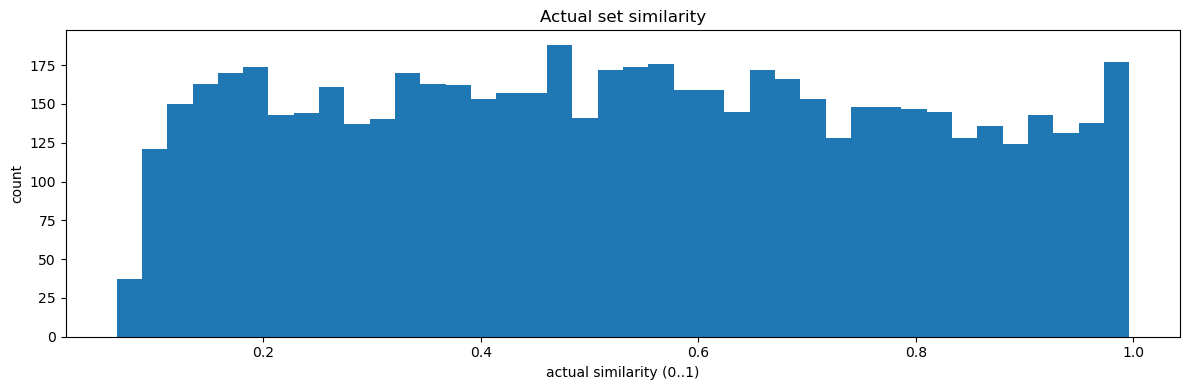

Done. Metadata: {'out_train_path': 'C:/Users/PC1/Downloads/train_similarity_final.npz', 'out_test_path': 'C:/Users/PC1/Downloads/test_similarity_final.npz', 'A_train_shape': 4800, 'A_test_shape': 1200, 'y_train_mean': 0.5346512794494629, 'y_train_std': 0.25822654366493225, 'max_norm_used': 3.1622776601683795}
Label mean/std: 0.5346512794494629 0.25822654366493225


In [ ]:
# ---------------- Main script to generate data and create DataLoaders ----------------
#Change paths as needed
TRAIN_PATH = 'C:/Users/PC1/Downloads/train_similarity_final.npz'
TEST_PATH  = 'C:/Users/PC1/Downloads/test_similarity_final.npz'
#Change paths as needed

BATCH = 128
random_set_sizes = False

meta = generate_and_save(
        out_train_path=TRAIN_PATH,
        out_test_path=TEST_PATH,
        M=6000,
        N=20,
        dim=10,
        sigma=0.03,
        rng_seed=20251031,
        test_fraction=0.2,
        max_norm_multiplier=1.0,        #norm changer
        save_label_as='similarity',   # change to 'cost' if you prefer
        shuffle_before_split=True,
        hausdorf=False,
        random_set_sizes=random_set_sizes
    )
print("Done. Metadata:", meta)

train_ds = PairSetDataset(TRAIN_PATH)
test_ds  = PairSetDataset(TEST_PATH)

#normalization of label
y_train_all = train_ds.y
#y_train_all = 1.0-y_train_all  # convert back to cost if needed
y_mean = float(y_train_all.mean())
y_std  = float(y_train_all.std()) if float(y_train_all.std())>0 else 1.0
print("Label mean/std:", y_mean, y_std)

from functools import partial
collate_fn_with_params = partial(collate_fn, random_set_sizes=random_set_sizes)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, collate_fn=collate_fn_with_params)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=True, collate_fn=collate_fn_with_params)

**Training sinkhorn model**

In [11]:
# ---------- hyperparameters ----------
INPUT_DIM = 10
HIDDEN_DIM = 64
EMB_DIM = 64
AGG = 'sum'
DROPOUT = 0.0

HEAD_HIDDEN = 128
LR = 1e-3
EPOCHS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

encoder = SinkhornSetNet(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, emb_dim=EMB_DIM,
                         cost_type='dot', sinkhorn_reg=0.1, sinkhorn_iters=30).to(device)

SINKHORN_REG = 0.1
SINKHORN_ITERS = 30

params = list(encoder.parameters())

opt = optim.Adam(params, lr=LR)
loss_fn = nn.MSELoss()

train_loss_epochs = []
test_mse_epochs = []

for epoch in range(1, EPOCHS + 1):
    encoder.train()
    running_loss = 0.0
    for A_batch, B_batch, y_batch, mask_batch in train_loader: #added mask_batch if random sizes
        A_batch = A_batch.to(device)
        B_batch = B_batch.to(device)
        y_batch = y_batch.to(device)

        if mask_batch is not None:
             mask_batch = mask_batch.to(device)

        # get per-point embeddings (no pooling)
        pred_costs = encoder(A_batch, B_batch, mask=mask_batch)

        # labels: convert similarity -> cost (since we saved similarity)
        y_cost = 1.0 - y_batch  # (B,) in [0,1]
        
        # LOSS: Compare Raw Prediction vs Raw Cost (0-1 range)
        loss = loss_fn(pred_costs, y_cost)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += float(loss.item()) * A_batch.size(0)

    train_loss_epoch = running_loss / len(train_loader.dataset)
    train_loss_epochs.append(train_loss_epoch)

    # ---------- evaluation ----------
    encoder.eval()

    total_mse = 0.0
    total_mae = 0.0
    relative = 0.0
    with torch.no_grad():
        for A_batch, B_batch, y_batch, mask_batch in test_loader:
            A_batch = A_batch.to(device)
            B_batch = B_batch.to(device)
            y_batch = y_batch.to(device)
            
            if mask_batch is not None:
                mask_batch = mask_batch.to(device)

            pred_costs = encoder(A_batch, B_batch, mask=mask_batch)
            
            pred_sim = 1.0 - pred_costs
            y_true_sim = y_batch
            mse_batch = ((pred_sim - y_true_sim) ** 2).sum().item()
            mae_batch = (pred_sim - y_true_sim).abs().sum().item()
            relative += relative_error(y_true_sim, pred_sim).item() * A_batch.size(0)

            total_mse += mse_batch
            total_mae += mae_batch

    test_mse = total_mse / len(test_loader.dataset)
    test_mae = total_mae / len(test_loader.dataset)
    relative /= len(test_loader.dataset)
    test_mse_epochs.append(test_mse)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}  train_loss={train_loss_epoch:.6f}  test_MSE={test_mse:.6f}  test_MAE={test_mae:.6f} relative_err={relative:.6f}")
# ---------- end of training ----------

Using device: cpu
Epoch 01  train_loss=0.019949  test_MSE=0.002577  test_MAE=0.038690 relative_err=0.027121
Epoch 05  train_loss=0.001306  test_MSE=0.001250  test_MAE=0.025892 relative_err=0.017698
Epoch 10  train_loss=0.000834  test_MSE=0.000828  test_MAE=0.021041 relative_err=0.014262
Epoch 15  train_loss=0.000642  test_MSE=0.000659  test_MAE=0.018848 relative_err=0.012715
Epoch 20  train_loss=0.000544  test_MSE=0.000577  test_MAE=0.018403 relative_err=0.012423
Epoch 25  train_loss=0.000485  test_MSE=0.000523  test_MAE=0.017044 relative_err=0.011485
Epoch 30  train_loss=0.000441  test_MSE=0.000484  test_MAE=0.016910 relative_err=0.011355
Epoch 35  train_loss=0.000399  test_MSE=0.000456  test_MAE=0.016078 relative_err=0.010804
Epoch 40  train_loss=0.000376  test_MSE=0.000429  test_MAE=0.015934 relative_err=0.010687
Epoch 45  train_loss=0.000358  test_MSE=0.000409  test_MAE=0.015244 relative_err=0.010218
Epoch 50  train_loss=0.000337  test_MSE=0.000394  test_MAE=0.014903 relative_err=0

**Evaluation of DeepSets model**

Final Test Results:
MSE=0.0003, RMSE=0.0177, MAE=0.0136, R2=0.9955, Corr=0.9981


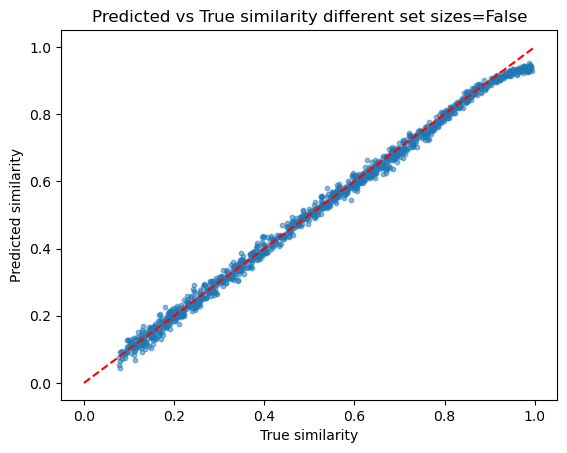

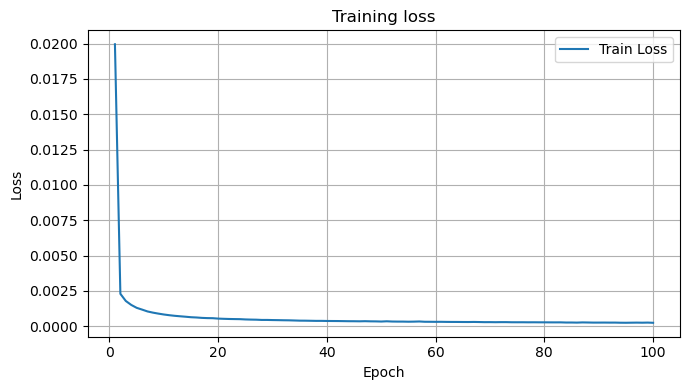

In [12]:
# ---------- final evaluation ----------
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for A_batch, B_batch, y_batch, mask_batch in test_loader:
        A_batch, B_batch = A_batch.to(device), B_batch.to(device)
        y_batch = y_batch.to(device)
        
        if mask_batch is not None:
             mask_batch = mask_batch.to(device)

        pred_costs = encoder(A_batch, B_batch, mask=mask_batch)

        # convert cost → similarity
        pred = 1.0 - pred_costs

        y_true_all.append(y_batch.cpu().numpy())
        y_pred_all.append(pred.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
corr = np.corrcoef(y_true_all, y_pred_all)[0,1]

print(f"Final Test Results:\nMSE={mse:.4f}, RMSE={np.sqrt(mse):.4f}, MAE={mae:.4f}, R2={r2:.4f}, Corr={corr:.4f}")

# ---------- scatter plot ----------
plt.scatter(y_true_all, y_pred_all, s=10, alpha=0.5)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("True similarity")
plt.ylabel("Predicted similarity")
plt.title(f"Predicted vs True similarity different set sizes={random_set_sizes}")
plt.show()

# ---------- plot training loss ----------
plt.figure(figsize=(7,4))
plt.plot(range(1, EPOCHS+1), train_loss_epochs, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Training DeepSets model**

In [13]:
# ---------- hyperparameters ----------
INPUT_DIM = 10
HIDDEN_DIM = 64
EMB_DIM = 64
AGG = 'sum'
DROPOUT = 0.0

HEAD_HIDDEN = 128
LR = 1e-3
EPOCHS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

encoder = DeepSets(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=EMB_DIM,
                   aggregator=AGG, dropout=DROPOUT).to(device)

head = Head(EMB_DIM, HEAD_HIDDEN).to(device)

params = list(encoder.parameters()) + list(head.parameters())

opt = optim.Adam(params, lr=LR)
loss_fn = nn.MSELoss()

train_loss_epochs = []
test_mse_epochs = []

# ---------- training loop ----------
for epoch in range(1, EPOCHS + 1):
    encoder.train()
    head.train()
    running_loss = 0.0
    for A_batch, B_batch, y_batch, mask_batch in train_loader: #added mask_batch if random sizes
        A_batch = A_batch.to(device)
        B_batch = B_batch.to(device)
        y_batch = y_batch.to(device)
        if mask_batch is not None:
            mask_batch = mask_batch.to(device)

        # original pooled-head training (unchanged)
        embA = encoder(A_batch, mask=mask_batch)   # (B, EMB_DIM)
        embB = encoder(B_batch, mask=mask_batch)
        
        pred = head(embA, embB)
        loss = loss_fn(pred, y_batch)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += float(loss.item()) * A_batch.size(0)

    train_loss_epoch = running_loss / len(train_loader.dataset)
    train_loss_epochs.append(train_loss_epoch)

    # ---------- evaluation ----------
    encoder.eval(); head.eval()

    total_mse = 0.0
    total_mae = 0.0
    relative = 0.0
    with torch.no_grad():
        for A_batch, B_batch, y_batch, mask_batch in test_loader:
            A_batch = A_batch.to(device)
            B_batch = B_batch.to(device)
            y_batch = y_batch.to(device)
            if mask_batch is not None:
                mask_batch = mask_batch.to(device)
            
            embA = encoder(A_batch, mask=mask_batch)
            embB = encoder(B_batch, mask=mask_batch)
            pred = head(embA, embB)
            
            mse_batch = ((pred - y_batch) ** 2).sum().item()
            mae_batch = (pred - y_batch).abs().sum().item()
            relative += relative_error(y_batch, pred).item() * A_batch.size(0)

            total_mse += mse_batch
            total_mae += mae_batch

    test_mse = total_mse / len(test_loader.dataset)
    test_mae = total_mae / len(test_loader.dataset)
    relative = relative / len(test_loader.dataset)
    test_mse_epochs.append(test_mse)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}  train_loss={train_loss_epoch:.6f}  test_MSE={test_mse:.6f}  test_MAE={test_mae:.6f}, relative_err={relative:.6f}")

Using device: cpu
Epoch 01  train_loss=0.040697  test_MSE=0.003605  test_MAE=0.048565, relative_err=0.032245
Epoch 05  train_loss=0.000867  test_MSE=0.000801  test_MAE=0.022442, relative_err=0.014836
Epoch 10  train_loss=0.000681  test_MSE=0.000585  test_MAE=0.019129, relative_err=0.012936
Epoch 15  train_loss=0.000503  test_MSE=0.000572  test_MAE=0.018676, relative_err=0.012466
Epoch 20  train_loss=0.000541  test_MSE=0.000389  test_MAE=0.015488, relative_err=0.010309
Epoch 25  train_loss=0.000380  test_MSE=0.000346  test_MAE=0.014677, relative_err=0.009799
Epoch 30  train_loss=0.000376  test_MSE=0.000309  test_MAE=0.013757, relative_err=0.009195
Epoch 35  train_loss=0.000432  test_MSE=0.000393  test_MAE=0.015596, relative_err=0.010152
Epoch 40  train_loss=0.000393  test_MSE=0.001520  test_MAE=0.035329, relative_err=0.024137
Epoch 45  train_loss=0.000263  test_MSE=0.000265  test_MAE=0.012728, relative_err=0.008477
Epoch 50  train_loss=0.000332  test_MSE=0.000336  test_MAE=0.014524, rel

**Evaluation of deepsets model**

Final Test Results:
MSE=0.0003, RMSE=0.0182, MAE=0.0145, R2=0.9952, Corr=0.9984


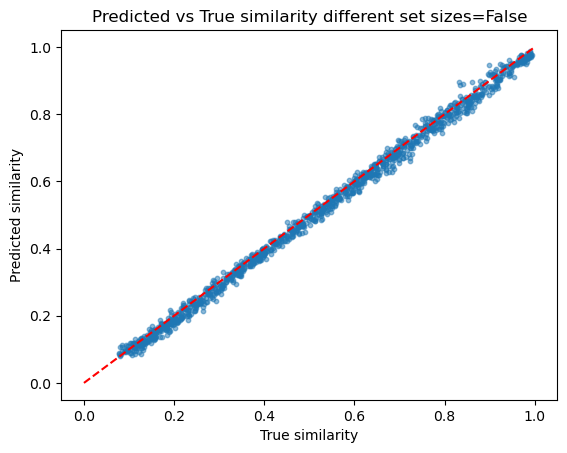

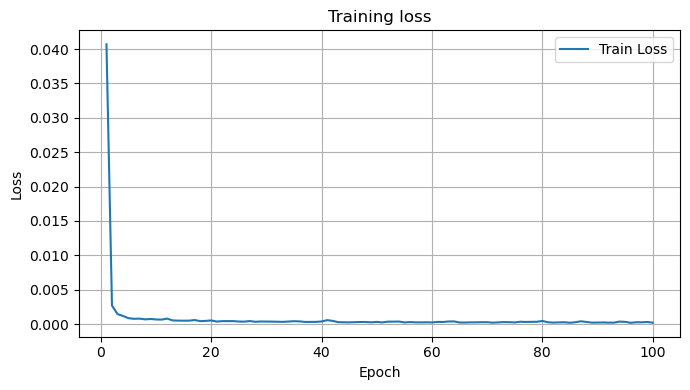

In [14]:
# ---------- final evaluation ----------
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for A_batch, B_batch, y_batch, mask_batch in test_loader:
        A_batch, B_batch = A_batch.to(device), B_batch.to(device)
        y_batch = y_batch.to(device)
        if mask_batch is not None:
            mask_batch = mask_batch.to(device)

        pred = head(encoder(A_batch, mask=mask_batch), encoder(B_batch, mask=mask_batch))
        
        y_true_all.append(y_batch.cpu().numpy())
        y_pred_all.append(pred.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
corr = np.corrcoef(y_true_all, y_pred_all)[0,1]

print(f"Final Test Results:\nMSE={mse:.4f}, RMSE={np.sqrt(mse):.4f}, MAE={mae:.4f}, R2={r2:.4f}, Corr={corr:.4f}")

# Plot predicted vs true
plt.scatter(y_true_all, y_pred_all, s=10, alpha=0.5)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("True similarity")
plt.ylabel("Predicted similarity")
plt.title(f"Predicted vs True similarity different set sizes={random_set_sizes}")
plt.show()

# ---------- plot training loss ----------
plt.figure(figsize=(7,4))
plt.plot(range(1, EPOCHS+1), train_loss_epochs, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()